In [11]:
import numpy as np
import pandas as pd
from scipy.stats import entropy
import scipy.stats
import sklearn.decomposition
import sklearn.manifold
import seaborn as sns
import matplotlib.pyplot as plt
% matplotlib inline

from lib import *

# Protein length distribution

20373

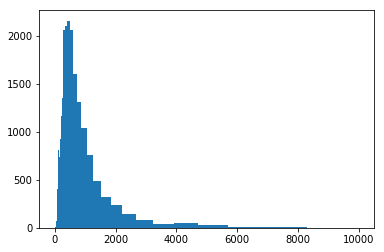

In [12]:
lens = []
for h, seq in fasta_iter(human):
    lens.append(len(seq))
nhuman = len(lens)
plt.hist(lens, bins=np.logspace(0, 4));
nhuman

# kmer distribution

In [13]:
counters = [count_kmers_proteome(human, k) for k in range(1, 8)]

1.137079e+07, 6.400000e+07


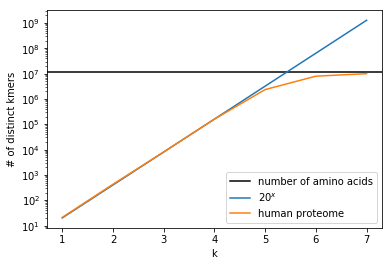

In [14]:
totalpeptides = np.sum(list(counters[0].values()))
print('%e, %e'%(totalpeptides, 20**6))
fig = plt.figure()
x = np.arange(1, 8)
plt.axhline(totalpeptides, color='k', label='number of amino acids')
plt.plot(x, 20**x, label='$20^x$')
plt.plot(range(1, len(counters)+1), [len(c) for c in counters], label='human proteome')
plt.yscale('log')
plt.xlabel('k')
plt.ylabel('# of distinct kmers')
plt.legend(loc='lower right')
fig.savefig('plots/kmerscaling.png', dpi=300)

In [15]:
df1 = counter_to_df(count_kmers_proteome(human, k=1))
df1.set_index('seq', inplace=True)

4.321928094887363 [4.16129306 4.14486763 4.1032921  3.82017209 2.19526829]


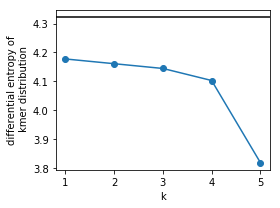

In [16]:
entropies = np.array([entropy(normalize(c), base=2) for i, c in enumerate(counters[:-1])])
print(np.log2(20), np.diff(entropies))
fig = plt.figure(figsize=(4, 3))
plt.plot(np.arange(1, len(counters))[:-1], np.append([entropies[0]], np.diff(entropies))[:-1], 'o-')
#plt.ylim(4.0, 4.35)
plt.axhline(np.log2(20), c='k')
plt.xlabel('k')
plt.ylabel('differential entropy of\n kmer distribution');
fig.tight_layout()
fig.savefig('plots/diffentropy.png', dpi=300)

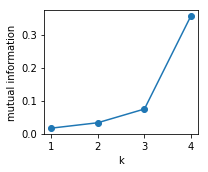

In [17]:
fig = plt.figure(figsize=(3, 2.5))
plt.plot(np.arange(1, len(counters)-1)[:-1], (entropies[0]-np.diff(entropies))[:-1], 'o-')
#plt.ylim(4.0, 4.35)
#plt.axhline(np.log2(20), c='k')
#plt.yscale('log')
plt.xlabel('k')
plt.ylabel('mutual information');
fig.tight_layout()
fig.savefig('plots/kmermutualinformation.png', dpi=300)

# lognormal distribution of word frequencies

In [21]:
df = counter_to_df(counters[0], norm=True)
df = df[~df['seq'].str.contains('U|B|X|Z')]
mu = np.mean(np.log10(df['freq']))
sigmasq = np.var(np.log10(df['freq']))
mu, sigmasq**.5

In [22]:
k = 9
k*mu, (k*sigmasq)**.5

(-12.160483995151004, 0.6691789298694757)

In [26]:
(1-10**(k*mu-2*(k*sigmasq)**.5))**(k*19*totalpeptides), (1-10**(k*mu-2*(k*sigmasq)**.5))**(totalpeptides*k*(k-1)*19*20)

(0.9999382624140302, 0.9901703116396322)

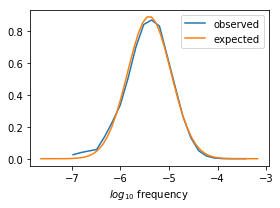

In [31]:
k = 4
df = counter_to_df(counters[k-1], norm=True)
df = df[~df['seq'].str.contains('U|B|X|Z')]
fig, ax = plt.subplots(figsize=(4, 3))
counts, bins = np.histogram(np.log10(df['freq']), bins=int(2*np.log(len(df['freq']))))
ax.plot(0.5*(bins[:-1]+bins[1:]), counts/(np.sum(counts)*np.diff(bins)), label='observed')
x = np.linspace(k*mu-5*(k*sigmasq)**.5, k*mu+5*(k*sigmasq)**.5)
plt.plot(x, scipy.stats.norm.pdf(x, k*mu, (k*sigmasq)**.5), label='expected')
plt.xlabel('$log_{10}$ frequency');
#plt.yscale('log')
plt.legend()
fig.tight_layout()
fig.savefig('plots/lognormal-wordfrequency-4mer.png', dpi=300)

# Comparison of human and pathogen proteome

In [11]:
df = counter_to_df(count_kmers_proteome(human, 1), norm=True)
df2 = counter_to_df(count_kmers_proteome(malaria, 1), norm=True)
dfmerged = pd.merge(df, df2, on='seq', suffixes=['_human', '_pathogen'])
dfmerged.to_csv('data.csv')

In [12]:
entropy(dfmerged['freq_human'], dfmerged['freq_pathogen']), entropy(dfmerged['freq_pathogen'], dfmerged['freq_human'])

(0.2346636095557455, 0.24755395990928056)

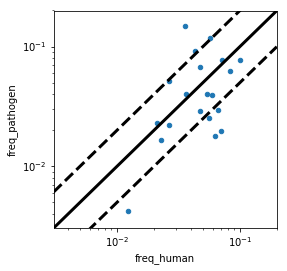

In [13]:
fig, ax = plt.subplots(figsize=(4, 4))
xmin, xmax = 0.25*np.amin(dfmerged['freq_human']), 2*np.amax(dfmerged['freq_human'])
x = np.logspace(np.log10(xmin), np.log10(xmax))
ax.plot(x, x, 'k', lw=3)
ax.plot(x, x*2, '--k', lw=3)
ax.set_xlim(xmin, xmax)
ax.set_ylim(xmin, xmax)
ax.plot(x, x/2, '--k', lw=3)
dfmerged.plot(x='freq_human', y='freq_pathogen', kind='scatter', logx=True, logy=True, ax=ax);

In [14]:
dfmerged['freq_human'].min()

0.012185344009928597

In [15]:
dfmerged['fold'] = dfmerged['freq_pathogen']/dfmerged['freq_human']
dfmerged.sort_values('fold', ascending=False)

,seq,freq_human,freq_pathogen,fold
15,N,0.035851,0.148551,4.143519
17,I,0.043349,0.091480,2.110320
7,K,0.057261,0.117360,2.049553
3,Y,0.026659,0.051345,1.925959
5,D,0.047393,0.066819,1.409900
14,F,0.036480,0.039934,1.094687
6,E,0.071046,0.077431,1.089879
0,M,0.021320,0.023123,1.084562
16,H,0.026240,0.022313,0.850324
8,L,0.099607,0.077088,0.773920


# doublet enrichment

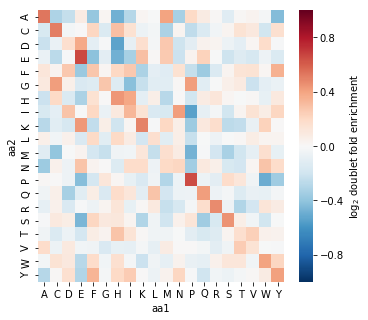

In [16]:
df1, df2 = counter_to_df(counters[0]), counter_to_df(counters[1])
df1.set_index('seq', inplace=True)
df2 = df2[~df2['seq'].str.contains('U|B|X|Z')]
strcolumn_to_charcolumns(df2, 'seq')
df2['theory'] = [float(df1.loc[s[0]] * df1.loc[s[1]]) for s in df2['seq']]
df2['fold'] = np.log2(df2['freq']/df2['theory'])
dfmat = df2.pivot(columns='aa1', index='aa2')['fold']
plt.figure(figsize=(5.5, 5))
sns.heatmap(dfmat, vmin=-1.0, vmax=1.0, cmap='RdBu_r', cbar_kws=dict(label='log$_2$ doublet fold enrichment'))

0.6663240200593604 0.04600750866988545 0.0014149224105342029


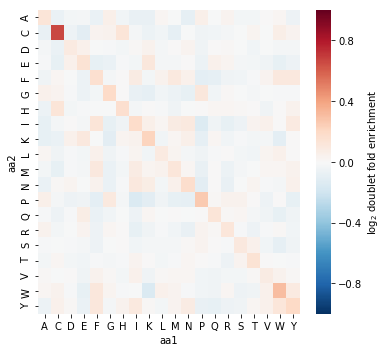

In [17]:
df1, df2 = counter_to_df(counters[0]), counter_to_df(count_kmers_iterable(scrambled(fasta_iter(human, returnheader=False)), k=2, gap=0))
df1.set_index('seq', inplace=True)
df2 = df2[~df2['seq'].str.contains('U')]
strcolumn_to_charcolumns(df2, 'seq')
df2['theory'] = [float(df1.loc[s[0]] * df1.loc[s[1]]) for s in df2['seq']]
df2['fold'] = np.log2(df2['freq']/df2['theory'])
print(np.abs(df2['fold']).max(), np.abs(df2['fold']).mean(), 2*entropies[0]-entropy(df2['freq'], base=2))
dfmat = df2.pivot(columns='aa1', index='aa2')['fold']
fig = plt.figure(figsize=(5.5, 5))
sns.heatmap(dfmat, vmin=-1.0, vmax=1.0, cmap='RdBu_r', cbar_kws=dict(label='log$_2$ doublet fold enrichment'))
fig.tight_layout()
fig.savefig('plots/doublet-shuffled.png', dpi=300)

In [18]:
df1, df2 = counter_to_df(counters[0], norm=True), counter_to_df(count_kmers_proteome(human, k=2, gap=20), norm=False)
df1.set_index('seq', inplace=True)
df2 = df2[~df2['seq'].str.contains('U')]
strcolumn_to_charcolumns(df2, 'seq')
df2['theory'] = [float(df1.loc[s[0]] * df1.loc[s[1]]*df2['count'].sum()) for s in df2['seq']]
pivot = df2.pivot(columns='aa1', index='aa2')

Text(0.5,0,'expected counts')

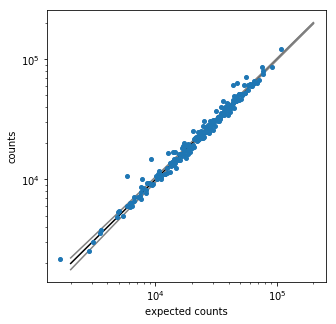

In [19]:
mask = np.tri(*pivot['count'].shape, k=-1)
plt.figure(figsize=(5, 5))
x = np.linspace(2e3, 2e5)
plt.plot(x, x, 'k')
plt.plot(x, x+5*x**.5, 'gray')
plt.plot(x, x-5*x**.5, 'gray')
arr = np.ma.array(pivot['theory'], mask=mask)
arrT = np.ma.array(pivot['count'], mask=mask)
plt.plot(arr.flatten(), arrT.flatten(), 'o', ms=4)
#plt.plot(x, 1.3*x, 'g')
#plt.plot(x, x/1.3, 'g')
plt.xscale('log')
plt.yscale('log')
plt.ylabel('counts')
plt.xlabel('expected counts')

# Mirror sequence analysis

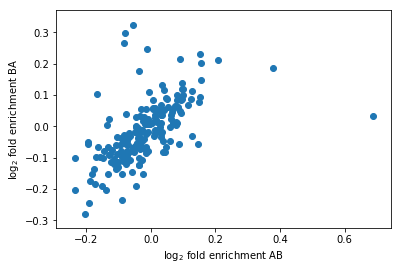

In [20]:
mask = np.tri(*pivot['count'].shape, k=0)
enrichment = np.log2(pivot['count']/pivot['theory'])
plt.scatter(np.ma.array(enrichment, mask=mask),
            np.ma.array(enrichment.T, mask=mask))
plt.xlabel('log$_2$ fold enrichment AB')
plt.ylabel('log$_2$ fold enrichment BA');

In [21]:
df2 = counter_to_df(counters[1], norm=False)
df2 = df2[~df2['seq'].str.contains('U')]
strcolumn_to_charcolumns(df2, 'seq')
counts = df2.pivot(columns='aa1', index='aa2')['count']

Text(0.5,0,'counts of AB')

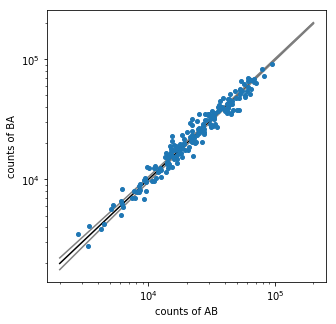

In [22]:
plt.figure(figsize=(5, 5))
x = np.linspace(2e3, 2e5)
plt.plot(x, x, 'k')
plt.plot(x, x+5*x**.5, 'gray')
plt.plot(x, x-5*x**.5, 'gray')
arr = np.ma.array(counts, mask=mask)
arrT = np.ma.array(counts.T, mask=mask)
plt.plot(arr.flatten(), arrT.flatten(), 'o', ms=4)
#plt.plot(x, 1.3*x, 'g')
#plt.plot(x, x/1.3, 'g')
plt.xscale('log')
plt.yscale('log')
plt.ylabel('counts of BA')
plt.xlabel('counts of AB')

Text(28.5,0.5,'amino acid 2')

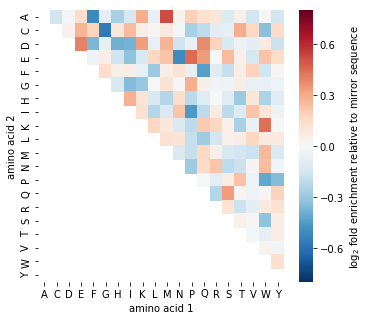

In [23]:
plt.figure(figsize=(5.5, 5))
fold = np.log2(counts/counts.T)
sns.heatmap(fold, mask=mask, vmin=-0.8, vmax=0.8, cmap='RdBu_r',
            cbar_kws=dict(label='log$_2$ fold enrichment relative to mirror sequence'))
plt.xlabel('amino acid 1')
plt.ylabel('amino acid 2')

# amino acid frequencies across different proteins

In [24]:
aas = unique_amino_acids(fasta_iter(human))

In [25]:
def aa_frequencies(proteome, min_length=1):
    n = sum([1 for h, seq in fasta_iter(proteome) if len(seq)>=min_length])
    array = np.zeros((n, len(aas)))
    i = 0
    for h, seq in fasta_iter(proteome):
        seq = seq.replace('X', '')
        if len(seq) < min_length:
            continue
        counter = {}
        for aa in aas:
            counter[aa] = 0
        count_kmers(seq, 1, counter=counter)
        sum_ = np.sum(list(counter.values()))
        for j, aa in enumerate(aas):
            array[i, j] = counter[aa]/sum_
        i += 1
    return array

In [26]:
min_length = 10
aa_human = aa_frequencies(human, min_length=min_length)
aa_malaria = aa_frequencies(malaria, min_length=min_length)
aa_influenzaB = aa_frequencies(influenzaB, min_length=min_length)
aa_cmv = aa_frequencies(cmv, min_length=min_length)
aa_listeria = aa_frequencies(listeria, min_length=min_length)
aa_hiv = aa_frequencies(hiv, min_length=min_length)

(-0.3, 0.3)

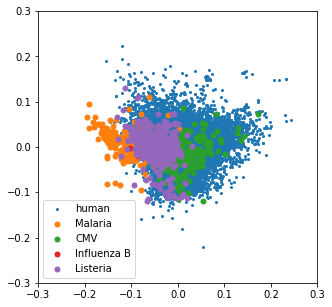

In [27]:
fig = plt.figure(figsize=(5, 5))
pca = sklearn.decomposition.PCA(n_components=2)
pcad_human = pca.fit_transform(aa_human)
plt.scatter(pcad_human[:, 0], pcad_human[:, 1], s=4, label='human')
for label, aa in [('Malaria', aa_malaria), ('CMV', aa_cmv), ('Influenza B', aa_influenzaB),  ('Listeria', aa_listeria)]:
    pcad_pathogen = pca.transform(aa)
    plt.scatter(pcad_pathogen[:, 0], pcad_pathogen[:, 1], label=label, s=25)
plt.legend()
lim = 0.3
plt.xlim(-lim, lim)
plt.ylim(-lim, lim)

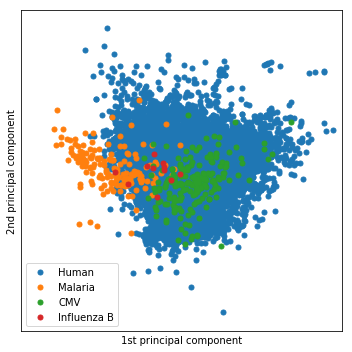

In [28]:
fig = plt.figure(figsize=(5, 5))
pca = sklearn.decomposition.PCA(n_components=2)
pca = pca.fit(np.vstack([aa_human, aa_malaria, aa_cmv, aa_influenzaB]))
for label, aa in [('Human', aa_human), ('Malaria', aa_malaria), ('CMV', aa_cmv), ('Influenza B', aa_influenzaB)]:
    pcad_pathogen = pca.transform(aa)
    plt.scatter(pcad_pathogen[:, 0], pcad_pathogen[:, 1], label=label, s=25)
plt.legend()
lim = 0.25
plt.xlim(-lim, lim)
plt.ylim(-lim, lim)
plt.xticks([])
plt.yticks([])
plt.xlabel('1st principal component')
plt.ylabel('2nd principal component')
fig.tight_layout()
fig.savefig('plots/pcaanalysis.png')

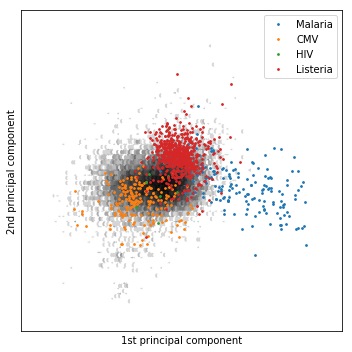

In [29]:
fig, ax = plt.subplots(figsize=(5, 5))
pca = sklearn.decomposition.PCA(n_components=2)
pca = pca.fit(np.vstack([aa_listeria, aa_malaria, aa_cmv, aa_hiv]))
pcad = pca.transform(aa_human)
ax.hexbin(pcad[:, 0], pcad[:, 1], bins='log', cmap='gray_r')
for label, aa in [('Malaria', aa_malaria), ('CMV', aa_cmv),
                  ('HIV', aa_hiv),
                  #('Influenza B', aa_influenzaB),
                  ('Listeria', aa_listeria)]:
    pcad_pathogen = pca.transform(aa)
    ax.scatter(pcad_pathogen[:, 0], pcad_pathogen[:, 1], label=label, s=3)
plt.legend()
lim = 0.25
plt.xlim(-lim, lim)
plt.ylim(-lim, lim)
plt.xticks([])
plt.yticks([])
plt.xlabel('1st principal component')
plt.ylabel('2nd principal component')
fig.tight_layout()
fig.savefig('plots/pcaanalysis.png', dpi=300)

In [30]:
trans = sklearn.manifold.MDS(n_components=2)
aafreqs = [aa_human[:1000, :], aa_malaria, aa_cmv, aa_influenzaB]
transd = trans.fit_transform(np.vstack(aafreqs))

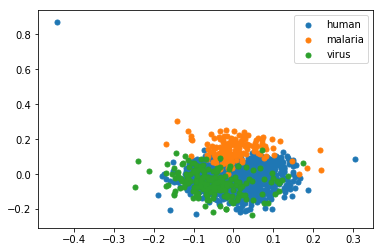

In [31]:
len_aafreqs = [aa.shape[0] for aa in aafreqs]
plt.scatter(transd[:len_aafreqs[0], 0], transd[:len_aafreqs[0], 1], label='human', s=25)
plt.scatter(transd[len_aafreqs[0]:len_aafreqs[0]+aa_malaria.shape[0], 0], transd[len_aafreqs[0]:len_aafreqs[0]+aa_malaria.shape[0], 1], label='malaria', s=25)
plt.scatter(transd[len_aafreqs[0]+aa_malaria.shape[0]:, 0], transd[len_aafreqs[0]+aa_malaria.shape[0]:, 1], label='virus', s=25)
plt.legend()

In [32]:
dfcmv = pd.read_csv('/home/amayer/data/proteomes/cmv-iedb-epitopes.csv', header=1, usecols=(2, 9))
dfcmv['length'] = [len(d) for d in dfcmv['Description']]

In [33]:
def aa_frequencies_list(list_, min_length=1):
    array = np.zeros((len(list_), len(aas)))
    i = 0
    for seq in list_:
        seq = ''.join( c for c in seq if c in list(aas))
        if len(seq) < min_length:
            continue
        counter = {}
        for aa in aas:
            counter[aa] = 0
        count_kmers(seq, 1, counter=counter)
        for j, aa in enumerate(aas):
            array[i, j] = counter[aa]
        i += 1
    return array

In [34]:
aa_cmv_epitopes = aa_frequencies_list(list(dfcmv[(dfcmv['length']<25)&(dfcmv['length']>5)]['Description']))
aa_cmv_epitope = aa_cmv_epitopes.sum(axis=0)
aa_cmv_epitope /= np.sum(aa_cmv_epitope)

aah = aa_human.sum(axis=0)
aah /= np.sum(aah)

aac = aa_cmv.sum(axis=0)
aac /= np.sum(aac)

In [35]:
df = pd.DataFrame(dict(freq=np.concatenate([aah, aac, aa_cmv_epitope]),
                       aas=np.concatenate([aas]*3),
                       provenance=np.concatenate([['human']*len(aas), ['cmv']*len(aas), ['cmv_epitope']*len(aas)])))
df.head()

,freq,aas,provenance
0,0.072147,A,human
1,0.025210,C,human
2,0.045321,D,human
3,0.067551,E,human
4,0.038138,F,human


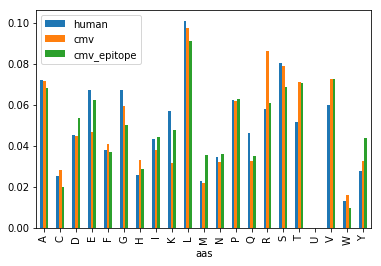

In [36]:
df = pd.DataFrame(dict(human=aah, cmv=aac, cmv_epitope=aa_cmv_epitope, aas=aas))
df.plot.bar(x='aas')

# Probability given independent model

In [37]:
df0 = counter_to_df(counters[0])
df0 = df0.set_index('seq')
humanaaprobdict = np.log10(df0['freq']).to_dict()
humanaaprobdict

{'M': -1.6712114813499508,
 'T': -1.2711748107115097,
 'G': -1.1822858153690639,
 'Y': -1.574150296127795,
 'P': -1.199876777577105,
 'D': -1.3242865229636032,
 'E': -1.1484615605550976,
 'K': -1.2421403136826479,
 'L': -1.0017079846543702,
 'R': -1.248516845414329,
 'Q': -1.3214333654093728,
 'W': -1.9141622055432883,
 'S': -1.0796273885260892,
 'V': -1.224272190158989,
 'F': -1.437944600451292,
 'N': -1.4454936422828286,
 'H': -1.5810355227957886,
 'I': -1.3630212858544604,
 'C': -1.6387759392376506,
 'A': -1.1537192183369989,
 'U': -5.487588953020592}

In [38]:
dfepitope = pd.read_csv('/home/amayer/data/proteomes/allhuman-iedb-epitopes.csv', header=1, usecols=(2, 9, 14))
dfepitope = dfepitope.fillna('')
counts = dfepitope.groupby('Parent Organism')['Description'].count()
counts.to_csv('organisms.csv')
counts[counts>300].sort_values()

Parent Organism
Human immunodeficiency virus 1                            310
Streptococcus pyogenes                                    331
Mus musculus                                              332
Alphapapillomavirus 9                                     339
Orthohepevirus A                                          364
Vaccinia virus                                            367
Primate T-lymphotropic virus 1                            371
Mycobacterium leprae                                      379
Severe acute respiratory syndrome-related coronavirus     386
Human alphaherpesvirus 2                                  418
Human gammaherpesvirus 8                                  432
Hepatitis B virus                                         464
Blattella germanica                                       490
Dermatophagoides                                          577
Arachis hypogaea                                          617
Phleum pratense                                       

correspondence:
Human gammaherpesvirus 4 = Epstein Barr virus (EBV)

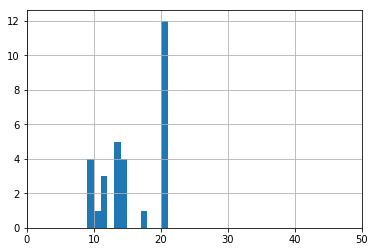

In [39]:
dfepitope = pd.read_csv('/home/amayer/data/proteomes/allhuman-iedb-epitopes.csv', header=1, usecols=(2, 9, 14))
dfepitope = dfepitope.fillna('')
dfepitope = dfepitope[dfepitope['Parent Organism'].str.contains('Influenza B')]
dfepitope['length'] = [len(d) for d in dfepitope['Description']]
dfepitope['length'].hist(bins=np.arange(50))
plt.xlim(0, 50);

In [40]:
k = 9
#epi = list(dfepitope[dfepitope['length']==k]['Description'])
epi = list(dfepitope['Description'])
pepitope = np.array([loglikelihood_independent(seq[i:i+k], humanaaprobdict, k) for seq in epi for i in range(len(seq)-k+1) ])
pepitope = pepitope[~np.isnan(pepitope)]
phuman = np.array([loglikelihood_independent(seq[i:i+k], humanaaprobdict, k) for h, seq in fasta_iter(human) for i in range(len(seq)-k+1) ])
ppathogen = np.array([loglikelihood_independent(seq[i:i+k], humanaaprobdict, k) for h, seq in fasta_iter(pseudoburk) for i in range(len(seq)-k+1) ])

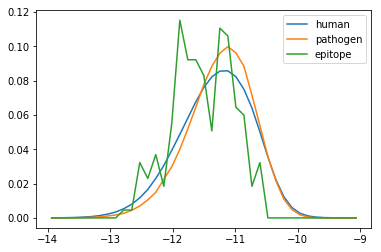

In [41]:
plot_histograms([phuman, ppathogen, pepitope], ['human', 'pathogen', 'epitope'])

In [42]:
np.mean(phuman), np.mean(ppathogen), np.mean(pepitope)

(-11.313289155910649, -11.240068990486174, -11.52827762601275)

In [43]:
df5 = counter_to_df(counters[5], norm=False)

In [44]:
#loglikelihood = lambda seq: loglikelihood_triplet(seq, humanaaprobdict, humandoubletprobdict, humantripletprobdict)
loglikelihood = lambda seq: loglikelihood_independent(seq, humanaaprobdict)
df5['theory'] = df5['count'].sum() * np.array([10**loglikelihood(seq) for seq in df5['seq'] ])

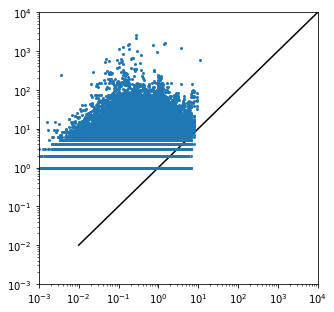

In [45]:
plt.figure(figsize=(5, 5))
x = np.linspace(1e-2, 1e4)
plt.plot(x, x, 'k')
#plt.plot(x, x+5*x**.5, 'gray')
#plt.plot(x, x-5*x**.5, 'gray')
plt.plot(df5['theory'], df5['count'], 'o', ms=2)
#plt.plot(x, 1.3*x, 'g')
#plt.plot(x, x/1.3, 'g')
plt.xlim(1e-3, 1e4)
plt.ylim(1e-3, 1e4)
plt.xscale('log')
plt.yscale('log')

# Probability given markov chain model

In [46]:
df1 = counter_to_df(counters[1], norm=False)
strcolumn_to_charcolumns(df1, 'seq')
count = df1.pivot(columns='aa1', index='aa2')['count']
count /= np.sum(count, axis=0)
count[count.isna()] = 1e-10
humandoubletprobdict = np.log10(count).to_dict()

In [47]:
epi = list(dfepitope['Description'])
pepitope_mc = np.array([loglikelihood_mc(seq[i:i+k], humanaaprobdict, humandoubletprobdict, k) for seq in epi for i in range(len(seq)-k+1)])
pepitope_mc = pepitope_mc[~np.isnan(pepitope_mc)]
phuman_mc = np.array([loglikelihood_mc(seq[i:i+k], humanaaprobdict, humandoubletprobdict, k) for h, seq in fasta_iter(human) for i in range(len(seq)-k+1)])
ppathogen_mc = np.array([loglikelihood_mc(seq[i:i+k], humanaaprobdict, humandoubletprobdict, k) for h, seq in fasta_iter(ebv) for i in range(len(seq)-k+1)])

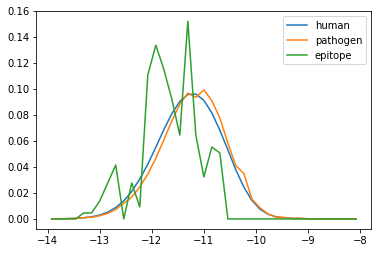

In [48]:
plot_histograms([phuman_mc, ppathogen_mc, pepitope_mc], ['human', 'pathogen', 'epitope'])

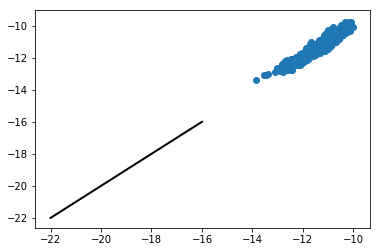

In [49]:
x = np.linspace(-22, -16)
plt.plot(x, x, 'k', lw=2)
plt.scatter(phuman[:1000], phuman_mc[:1000])

/home/amayer/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/home/amayer/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


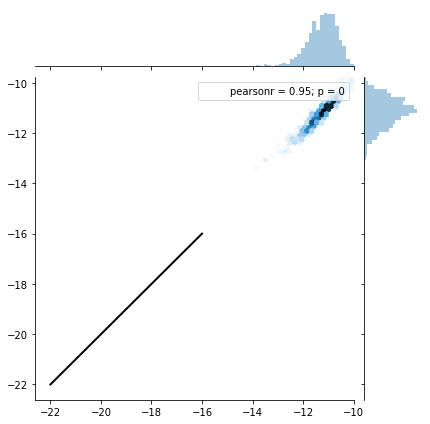

In [50]:
j = sns.jointplot(x=phuman[:1000], y=phuman_mc[:1000], kind="hex",
                 joint_kws=dict(gridsize=20));
j.ax_joint.plot(x, x, 'k', lw=2)

In [51]:
np.mean(phuman), np.mean(phuman_mc)

(-11.313289155910649, -11.280346077803273)

In [52]:
df2 = counter_to_df(counters[2], norm=False)
df2['aa12'] = [s[:2] for s in df2['seq']]
df2['aa3'] = [s[2] for s in df2['seq']]
count = df2.pivot(columns='aa12', index='aa3')['count']
count /= np.sum(count, axis=0)
count[count.isna()] = 1e-10
humantripletprobdict = np.log10(count).to_dict()

In [53]:
epi = list(dfepitope['Description'])
pepitope_tri = np.array([loglikelihood_triplet(seq[i:i+k], humanaaprobdict, humandoubletprobdict, humantripletprobdict, k) for seq in epi for i in range(len(seq)-k+1)])
pepitope_tri = pepitope_tri[~np.isnan(pepitope_tri)]
phuman_tri = np.array([loglikelihood_triplet(seq[i:i+k], humanaaprobdict, humandoubletprobdict, humantripletprobdict, k) for h, seq in fasta_iter(human) for i in range(len(seq)-k+1)])
ppathogen_tri = np.array([loglikelihood_triplet(seq[i:i+k], humanaaprobdict, humandoubletprobdict, humantripletprobdict, k) for h, seq in fasta_iter(ebv) for i in range(len(seq)-k+1)])

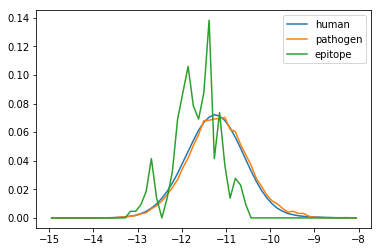

In [54]:
plot_histograms([phuman_tri, ppathogen_tri, pepitope_tri], ['human', 'pathogen', 'epitope'], nbins=60)

In [55]:
np.mean(pepitope)-np.mean(phuman), np.mean(pepitope)-np.mean(ppathogen)

(-0.2149884701021012, -0.2882086355265763)

In [56]:
np.mean(pepitope_mc)-np.mean(phuman_mc), np.mean(pepitope_mc)-np.mean(ppathogen_mc), 

(-0.38926043162125623, -0.45698400905760117)

In [57]:
np.mean(pepitope_tri)-np.mean(phuman_tri), np.mean(pepitope_tri)-np.mean(ppathogen_tri), 

(-0.4232482139592886, -0.4861153377704497)

# Using protein abundance information

In [58]:
paxdb = pd.read_csv('/home/amayer/data/proteomes/paxdb/9606-WHOLE_ORGANISM-integrated.txt', delimiter='\t', header=11)
paxdb['string_external_id'] = [s[5:] for s in paxdb['string_external_id']]
paxdb.head()

,internal_id,string_external_id,abundance
0,1855200,ENSP00000359240,1.190
1,1855297,ENSP00000359596,0.556
2,1855144,ENSP00000358965,0.002
3,1848483,ENSP00000303057,8.250
4,1842889,ENSP00000222157,0.203


In [59]:
uniprot_to_paxdb = pd.read_csv('/home/amayer/data/proteomes/paxdb/full_uniprot_2_paxdb.04.2015.tsv', delimiter='\t')
uniprot_to_paxdb['uniprot'] = [s.split('|')[0] for s in uniprot_to_paxdb['uniprot']]
uniprot_to_paxdb = uniprot_to_paxdb[uniprot_to_paxdb['organism']==9606]
uniprot_to_paxdb.head()

,organism,uniprot,ENSP,bla,blub
760420,9606,P31946,ENSP00000300161,100.0,508.0
760421,9606,P62258,ENSP00000264335,100.0,524.0
760422,9606,Q04917,ENSP00000248975,100.0,503.0
760423,9606,P61981,ENSP00000306330,100.0,509.0
760424,9606,P31947,ENSP00000340989,100.0,509.0


In [60]:
hs, seqs = list(zip(*((h.split('|')[1], seq) for h, seq in fasta_iter(human))))
dfuniprot = pd.DataFrame(dict(name=hs, sequence=seqs))
dfuniprot.head()

,name,sequence
0,O95139,MTGYTPDEKLRLQQLRELRRRWLKDQELSPREPVLPPQKMGPMEKF...
1,O75438,MVNLLQIVRDHWVHVLVPMGFVIGCYLDRKSDERLTAFRNKSMLFK...
2,Q8N4C6,MDEVEQDQHEARLKELFDSFDTTGTGSLGQEELTDLCHMLSLEEVA...
3,Q8IY84,MTAVYMNGGGLVNPHYARWDRRDSVESGCQTESSKEGEEGQPRQLT...
4,Q7RTP0,MGTAAAAAAAAAAAAAGEGARSPSPAAVSLGLGVAVVSSLVNGSTF...


In [61]:
merged = paxdb.merge(uniprot_to_paxdb, left_on='string_external_id', right_on='ENSP')
dfuniprot = dfuniprot.merge(merged, left_on='name', right_on='uniprot')
dfuniprot = dfuniprot.filter(items=['name', 'sequence', 'abundance'])

In [62]:
seqs = dfuniprot[dfuniprot['abundance']<0.01]['sequence']
len(seqs)

954

In [63]:
k = 9
phuman_mc = np.array([loglikelihood_mc(seq[i:i+k], humanaaprobdict, humandoubletprobdict, k) for h, seq in fasta_iter(human) for i in range(len(seq)-k+1)])
pabundant_mc = np.array([loglikelihood_mc(seq[i:i+k], humanaaprobdict, humandoubletprobdict, k) for seq in seqs for i in range(len(seq)-k+1)])

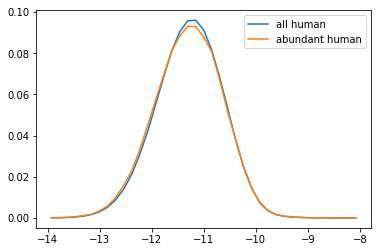

In [64]:
plot_histograms([phuman_mc, pabundant_mc], ['all human', 'abundant human'])

# Distribution of mitochondrial genes

In [65]:
df_mitocarta = pd.read_csv('/home/amayer/Dropbox/mtantigens/data/human-mitocarta.csv', sep='\t', usecols=(0, 4))

In [66]:
df_mitocarta['uniprot'] = [s[-6:] for s in df_mitocarta['Synonyms']]
df_mitocarta.head()

,TrainingDataset,Synonyms,uniprot
0,Tmito,MC3DN6|UQCR4|P08574,P08574
1,Tmito,CWS2|IP|PGL4|SDH|SDH1|SDH2|SDHIP|P21912,P21912
2,Tmito,CAT5|CLK-1|CLK1|Q99807,Q99807
3,Tmito,CMD1GG|FP|PGL5|SDH1|SDH2|SDHF|P31040,P31040
4,Tmito,D3S3191|QCR1|UQCR1|P31930,P31930


In [67]:
dfuniprot = dfuniprot.merge(df_mitocarta, left_on='name', right_on='uniprot')

In [68]:
seqs = dfuniprot[dfuniprot['TrainingDataset'] == 'Tmito']['sequence']
len(seqs)

956

In [69]:
k = 9
phuman_mc = np.array([loglikelihood_mc(seq[i:i+k], humanaaprobdict, humandoubletprobdict, k) for h, seq in fasta_iter(human) for i in range(len(seq)-k+1)])
pabundant_mc = np.array([loglikelihood_mc(seq[i:i+k], humanaaprobdict, humandoubletprobdict, k) for seq in seqs for i in range(len(seq)-k+1)])

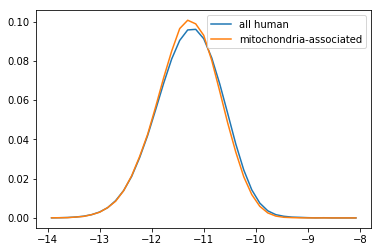

In [70]:
plot_histograms([phuman_mc, pabundant_mc], ['all human', 'mitochondria-associated'])

In [71]:
hs, seqs = list(zip(*((h.split('|')[1], seq) for h, seq in fasta_iter(human) if 'GN=MT-' in h)))
dfmt = pd.DataFrame(dict(name=hs, sequence=seqs))
seqs = dfmt['sequence']
len(seqs)

15

In [72]:
k = 9
phuman_mc = np.array([loglikelihood_mc(seq[i:i+k], humanaaprobdict, humandoubletprobdict, k) for h, seq in fasta_iter(human) for i in range(len(seq)-k+1)])
pabundant_mc = np.array([loglikelihood_mc(seq[i:i+k], humanaaprobdict, humandoubletprobdict, k) for seq in seqs for i in range(len(seq)-k+1)])

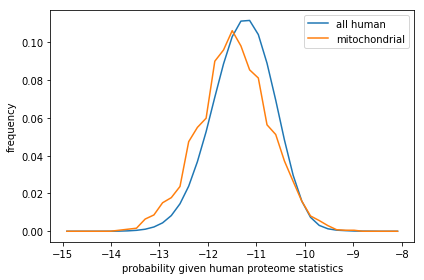

In [73]:
fig, ax = plt.subplots()
plot_histograms([phuman_mc, pabundant_mc], ['all human', 'mitochondrial'])
ax.set_ylabel('frequency')
ax.set_xlabel('probability given human proteome statistics')
fig.tight_layout()
fig.savefig('plots/likelihoodprofile-mitochondria.png', dpi=300)

In [74]:
np.mean(phuman_mc), np.mean(pabundant_mc)

(-11.280346077803273, -11.45856754407937)